# Decision Trees Exercise
In this exercise you will show that ID3 is sub-optimal. Implement a simple version of Random Forest, and will then apply a Decision Tree classsifier and random forest on the MNIST hand written digits dataset that we already saw.


## Suboptimality of ID3
Consider the following training set, where $\mathcal{X} = \{0, 1\}^3$ and $\mathcal{Y} =\{0, 1\}$:

$$
\begin{aligned}
((1, 1, 1), 1)\\
((1, 0, 0), 1)\\
((1, 1, 0), 0)\\
((0, 0, 1), 0)
\end{aligned}
$$

Suppose we wish to use this training set in order to build a decision tree of depth 2 (i.e. for each
input we are allowed to ask two questions of the form "$x_i = 0$?" before deciding on the label).

1. Suppose we run the ID3 algorithm up to depth 2 (namely, we pick the root node and its
children according to the algorithm, but instead of keeping on with the recursion, we stop
and pick leaves according to the majority label in each subtree, once we reach depth 2). 
Assume that the subroutine used to measure the quality of each feature is based on the information gain, and that if two features get the same score, one of them is picked arbitrarily. 
Show that the training error of the resulting decision tree is at least 1/4.
2. Find a decision tree of depth 2, which attains zero training error.


In [14]:
from itertools import product

import numpy as np
from scipy.stats import mode
from sklearn.datasets import load_boston

%matplotlib inline

In [2]:
# Classes for decision tree and decision node, not documented well enough because this was a fairly simple tree
# The tree in question 2 is similar in most parts and is heavily documented

class DecisionTree:
    """
    Class for simple decision tree classifier. Accepts only binary features, predicts binary classes.
    """
    def __init__(self, binary_features=None, max_depth=None):
        self.root = DecisionNode(tree=self, depth=0)
        self.data = None
        self.binary_features = binary_features
        self.labels = None
        self.classes = None
        self.max_depth = max_depth

    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        self.classes = np.unique(self.labels)
        self.root.data_indexes = np.arange(len(data))
        self.root.expand_node()

    def predict(self, test_data):
        predictions = np.zeros(len(test_data))
        for i, sample in enumerate(test_data):

            node = self.root

            while node.label is None:
                if sample[node.feature] == 0:
                    node = node.left
                else:
                    node = node.right

            predictions[i] = node.label

        return predictions

    def error(self, predictions, labels):
        return np.mean(predictions != labels)


class DecisionNode:
    def __init__(self, tree=None, right=None, left=None,
                 data_indexes=None, entropy=None, depth=None, label=None, feature=None):
        self.tree = tree
        self.right = right
        self.left = left
        self.data_indexes = data_indexes
        self.entropy = entropy
        self.depth = depth
        self.label = label
        self.feature = feature

    def expand_node(self):
        self.entropy = self._calc_entropy(self.data_indexes)
        if (self.depth == self.tree.max_depth) or (len(self.data_indexes) == 1):
            self.label = mode(self.tree.labels[self.data_indexes])[0][0]
        else:
            self.feature, left_indexes, right_indexes = self._choose_best_split(self.data_indexes)
            if len(left_indexes)>0:
                self.left = DecisionNode(tree=self.tree, data_indexes=left_indexes, depth=self.depth+1)
                self.left.expand_node()
            if len(right_indexes)>0:
                self.right = DecisionNode(tree=self.tree, data_indexes=right_indexes, depth=self.depth+1)
                self.right.expand_node()

    def _choose_best_split(self, data_indexes):
        entropies = []
        splits = []
        for feat in self.tree.binary_features:
            left, right = [np.where(self.tree.data[data_indexes][:, feat] == val)[0] for val in [0,1]]
            left_entropy = self._calc_entropy(left)
            right_entropy = self._calc_entropy(right)
            total_entropy = (len(left)/len(data_indexes))*left_entropy + (len(right)/len(data_indexes))*right_entropy
            splits.append([left, right])
            entropies.append(total_entropy)

        best_feature = self.tree.binary_features[np.array(entropies).argmin()]
        left_indexes, right_indexes = splits[np.array(entropies).argmin()]
        if best_feature in self.tree.binary_features:
            self.tree.binary_features.remove(best_feature)

        return best_feature, left_indexes, right_indexes


    def _calc_entropy(self, data_indexes):
        entropy = 0
        for cls in self.tree.classes:
            cls_prob = np.sum(self.tree.labels[data_indexes] == cls) / len(self.tree.labels[data_indexes])
            if cls_prob == 0:
                continue
            else:
                entropy -= cls_prob * np.log2(cls_prob)
        return entropy


In [3]:
x = np.array([[1,1,1],
             [1,0,0],
             [1,1,0],
             [0,0,1]])
y = np.array([1,1,0,0])
clf = DecisionTree(binary_features=[0, 1, 2], max_depth=2)
clf.fit(x, y)
pred = clf.predict(x)
error = clf.error(pred, y)
print(f'Predictions are: {pred}, training error is {error}')

Predictions are: [0. 1. 0. 0.], training error is 0.25


#### Answer
1. As shown in the code above, implementing an ID3 decision tree, the error on the training set is 0.25.
2. Consider a tree with `x2=0 (y=left,n=right)` as it's root node, and two children nodes which both have `x3=0 (y=left,n=right)`, the leaf predictions from right to left will be `[1,0,0,1]`. When using the tree to predict on our sample data, each sample will go to a different leaf and will be predicted correctly, acheiving an error of 0 (this can be acheived with an id3 tree if the first feature is removed). See diagram of tree:
![title](w1_q1_tree2.png)

## Implementing Random Forest From Scratch
In this exercise you will need to implement a simple version of Random Forest Regressor from scratch. Your decision tree will handle **continuous input and output** (this should actually work also for binary input attributes). 

* Compelete the skeleton class below (hint: you should also create a `DecisionTree` class that the `TreeEnsemble` will use)
  - `X` is a matrix of data values (rows are samples, columns are attributes)
  - `y` is a vector of corresponding target values
  - `n_trees` is the number of trees to create
  - `sample_sz` is the size of the sample set to use of each of the trees in the forest (chose the samples randomly, with or without repetition)
  - `min_leaf` is the minimal number of samples in each leaf node of each tree in the forest
  
* For splitting criterion, use either **"Train Squared Error Minimization (Reduction in Variance)"** or **"Train Absolute Error Minimization"** (choose one). Whatever you choose, make sure you implement the splitting point decision efficiently (in $O(n)$ time).

* The `predict` function will use mean of the target values in the leaf node matching each row of the given `X`. The result is a vector of predictions matching the number of rows in `X`.

* The `oob_mse` function will compute the mean squared error over all **out of bag (oob)** samples. That is, for each sample calculate the squared error using  predictions from the trees that do not contain x in their respective bootstrap sample, then average this score for all samples. See:  [OOB Errors for Random Forests](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html).

* To check your random forest implementation, use the boston dataset (`from sklearn.datasets import load_boston`)

  - Use the following to estimate what are the best hyper parameters to use for your model
```
for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for min_leaf in [1,5]:
      forest = TreeEnsemble(X, y, n, sz, min_leaf)
      mse = forest.oob_mse()
      print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))
```
  
  - Using your chosen hyperparameters as a final model, plot the predictions vs. true values of all the samples in the training set . Use something like:
  ```
  y_hat = forest.predict(X)  # forest is the chosen model
  plt.scatter(y_hat, y)
  ```
  



In [4]:
class DecisionNode:
    """
    Class for decision node, represents one node (split or leaf) in a decision tree regressor.
    Attributes:
        tree (DecisionTree): the decision tree which the node belongs to
        right (DecisionNode): the right child node of a node, None for a leaf
        left (DecisionNode): the left child node of a node, None for a leaf
        data_indexes (np array): the indexes of the data that has "reached" this node in training
        label (float): the label/prediction value for this node, None for splits (non-leaves)
        split_feature (int): the index of the feature that this node will split the data by, None for a leaf
        split_feature (float): the value of the feature that this node will split the data by, None for a leaf
    """
    def __init__(self, tree, right=None, left=None, data_indexes=None,
                 label=None, split_feature=None, split_value=None):
        self.tree = tree
        self.right = right
        self.left = left
        self.data_indexes = data_indexes
        self.label = label
        self.split_feature = split_feature
        self.split_value = split_value

    def expand_node(self):
        """
        Recursive method which is the heart of building the tree, called initially by the <tree>'s fit method in the
        training stage. For a given node, the optimal feature and value are found and assigned to the node`s attributes,
        The dataset is then split according to these, and 2 new nodes are created with each subset of the data. These
        nodes are then assigned as children nodes of the current node, via it`s attributes. The method is then called
        (recursion) on each of these children nodes. Before creating child nodes, the method checks the size of the 2
        subsets of data received after the split, if one of them is lesser than <tree.min_leaf>, they are not created
        and the node is turned into a leaf and assigns <label> with the mean value of all the samples which have
        "reached" the node.
        """
        split_feature, split_value, left_indexes, right_indexes = self._choose_best_split(self.data_indexes)

        if min(len(left_indexes), len(right_indexes)) < self.tree.min_leaf:
            self.label = self.tree.labels[self.data_indexes].mean()

        else:
            self.split_feature = split_feature
            self.split_value = split_value
            self.left = DecisionNode(tree=self.tree, data_indexes=left_indexes)
            self.left.expand_node()
            self.right = DecisionNode(tree=self.tree, data_indexes=right_indexes)
            self.right.expand_node()

    def _choose_best_split(self, data_indexes):
        """
        Method which finds the best feature to split the node's data on. A random subset of the features is taken into
        account if <tree.num_features> is not None. The best value to split the feature on for each feature is received
        from the <_find_optimal_split_for_feature> method together with it's splitting criterion value (mse), these
        values are compared over the features and the minimal is selected.
        """

        if self.tree.num_features is None:
            features = np.arange(self.tree.data.shape[1])
        else:
            features = np.random.choice(np.arange(self.tree.data.shape[1]), self.tree.num_features, replace=False)

        mse_vals = []
        splits = []
        for feat in features:
            left, right, mse, val = self._find_optimal_split_for_feature(feat)
            splits.append([left, right, val])
            mse_vals.append(mse)

        best_feature = features[np.array(mse_vals).argmin()]
        left_indexes, right_indexes, split_value = splits[np.array(mse_vals).argmin()]

        return best_feature, split_value, left_indexes, right_indexes

    def _find_optimal_split_for_feature(self, feat):
        """
        For a specific feature, finds the optimal value to split it on, according to split criterion (mse). First, sort
        the unique values of the samples associated with the node on the specified feature. Then extract the "mid values",
        the average between each one of the original unique values. Split the data on each one of these values and
        calculate mse. Choose the value which minimizes the mse. Return the indexes of each side of the split, the value
        to split on, and the mse of the split.
        """

        sorted_indexes = self.data_indexes[self.tree.data[self.data_indexes, feat].argsort()]
        sorted_v = np.unique(self.tree.data[sorted_indexes, feat])
        mid_values = np.array([sorted_v[i] + (sorted_v[i + 1] - sorted_v[i]) / 2
                               for i in range(len(sorted_v) - 1)])

        # if there are 0 middle values, there is only one value for this feature on these indexes, not possible to split
        if len(mid_values) == 0:
            return [], [], np.inf, 0

        mse_vals = []
        splits = []

        for i, value in enumerate(mid_values):
            left = self.data_indexes[self.tree.data[self.data_indexes, feat] < value]
            right = self.data_indexes[self.tree.data[self.data_indexes, feat] > value]
            mse_left = self._calc_mse(left)
            mse_right = self._calc_mse(right)
            total_mse = (len(left)/len(self.data_indexes))*mse_left + (len(right)/len(self.data_indexes))*mse_right
            splits.append([left, right])
            mse_vals.append(total_mse)

        best_left, best_right = splits[np.array(mse_vals).argmin()]
        best_mse = np.array(mse_vals).min()
        best_val = mid_values[np.array(mse_vals).argmin()]
        return best_left, best_right, best_mse, best_val

    def _calc_mse(self, data_indexes):
        """
        Calculate the split criterion (mse), for a group of samples, extracted from their indexes which are passed as
        a parameter. In this tree the prediction is the mean value of the specified samples, so the mse is actually
        equivalent to the population variance of the labels of these samples.
        """
        if len(data_indexes) == 0:
            return 0
        else:
            prediction = self.tree.labels[data_indexes].mean()
            mse = np.mean(np.square(self.tree.labels[data_indexes] - prediction))
            return mse


In [5]:
class DecisionTree:
    """
    Class for id3 decision tree regressor, uses class DecisionNode which represents one node or leaf of the tree.
    Attributes:
        root (DecisionNode): The root node of the tree (the first split)
        data (np array): the data used to train the regressor, includes all samples
        labels (np array): the labels of each sample of the data
        min_leaf (int): minimum number of samples allowed to be in a leaf
        num_features (int): number of features to be randomly sampled for each split, None = use all features
    """
    def __init__(self, min_leaf, num_features=None):
        self.root = DecisionNode(tree=self)
        self.data = None
        self.labels = None
        self.min_leaf = min_leaf
        self.num_features = num_features

    def fit(self, data, labels):
        """
        The training method. receives data and labels, initializes the root node with all the data indexes, and calls
        the node's expand_node method to begin the recursive building of the tree.
        """
        self.data = data
        self.labels = labels
        self.root.data_indexes = np.arange(len(data))
        self.root.expand_node()

    def predict(self, test_data):
        """
        The testing method, receives an array of testing samples, passes each one through the tree to receive a
        prediction. Starting from the root node, if the node doesnt contain an assigned label, then compare the node's
        split feature and value to the sample's value on that feature. If the sample's value is lesser - let it
        continue to the left child node, else continue to the right child node. Continue recursively until reaching
        a node which has a label value (a leaf), assign this label as the prediction for this sample.
        """
        # Reshape for a single sample
        if test_data.ndim == 1:
            test_data = np.expand_dims(test_data,0)

        predictions = np.zeros(len(test_data))
        for i, sample in enumerate(test_data):
            node = self.root
            while node.label is None:
                if sample[node.split_feature] < node.split_value:
                    node = node.left
                else:
                    node = node.right

            predictions[i] = node.label

        return predictions

In [8]:
class TreeEnsemble:
    """
    Class for random forest regressor, accepts continuous and binary features, splitting criterion is train mse.
    Attributes:
        n_trees (int): number of decision tree regressors in the forest
        sample_sz (int): sample size to use for training each tree
        min_leaf (int): minimum number of samples allowed to be in a leaf
        num_features (int): number of features to be randomly sampled for each split, None = use all features
        trees (list): list of all DecisionTree regressors used by the forest
        included_samples (list): list of indexes of included samples for each tree
        data (np array): the data used to train the regressor, includes all samples
        labels (np array): the labels of each sample of the data
    """
    def __init__(self, n_trees, sample_sz, min_leaf, num_features=None):
        self.n_trees = n_trees
        self.sample_sz = sample_sz
        self.min_leaf = min_leaf
        self.num_features = num_features
        self.trees = []
        self.included_samples = []
        self.data = None
        self.labels = None

    def fit(self, data, labels):
        """
        The training method - building the forest. Build <n_trees> trees, for each tree create a bootstrap of the data
        with replacement such that the size of the sample is <sample_sz>, train the tree on the samples.Save each tree
        and the indexes sampled for it in <trees> and <included_samples> respectively.
        """
        self.data = data
        self.labels = labels

        for i in range(self.n_trees):
            samples = np.random.choice(np.arange(len(self.data)), replace=True, size=self.sample_sz)
            tree = DecisionTree(min_leaf=self.min_leaf, num_features=self.num_features)
            tree.fit(self.data[samples], self.labels[samples])
            self.included_samples.append(np.unique(samples))
            self.trees.append(tree)

    def predict(self, x):
        """
        Testing method, passes each training sample through each one of the trees in the forest to receive a prediction.
        After receiving <n_trees> predictions for a sample, the mean of these is used as the aggregated prediction.
        Args:
            x (np array): the testing samples
        Returns:
             aggregated_predictions (np array): aggregated predictions for each sample
        """
        prediction_matrix = np.zeros((len(x), self.n_trees))
        for i, tree in enumerate(self.trees):
            prediction_matrix[:, i] = tree.predict(x)

        aggregated_predictions = prediction_matrix.mean(axis=1)
        return aggregated_predictions

    def oob_mse(self):
        """
        Out of bag mean squared error calculation. Take each one of the training samples in <data>, pass it only through
        the trees which it has not been sampled to train (use <included_samples> to check) and receive predictions. Use
        the mean of these predictions as the aggregated prediction for this sample, then calculate the squared error
        between the prediction and the label. Calculate the mean over these errors to receive the oob_mse (float).
        """
        mse_vals = []

        for i, sample in enumerate(self.data):
            predictions = []
            for j, tree in enumerate(self.trees):
                if i not in self.included_samples[j]:
                    predictions.append(tree.predict(sample))
            if len(predictions) == 0:
                continue
            agg_pred = np.array(predictions).mean()
            mse_val = np.square(self.labels[i] - agg_pred)
            mse_vals.append(mse_val)

        return np.array(mse_vals).mean()


In [9]:
np.random.seed(42)
x, y = load_boston(return_X_y=True)
param_grid = list(product([1, 5, 10, 20, 50, 100], [50, 100, 300, 500], [1, 5], [3, 6, None]))
oob_mse_vals = []
regressors = []

for params in param_grid:
    n, sz, min_leaf, num_features = params
    forest = TreeEnsemble(n, sz, min_leaf, num_features=6)
    forest.fit(x, y)
    mse = forest.oob_mse()
    oob_mse_vals.append(mse)
    regressors.append(forest)
    print(f'n_trees:{n}, sz:{sz}, min_leaf:{min_leaf}, num_features:{num_features} --- oob mse: {mse}')

n_trees:1, sz:50, min_leaf:1, num_features:3 --- oob mse: 83.10342047930284
n_trees:1, sz:50, min_leaf:1, num_features:6 --- oob mse: 44.828056155507554
n_trees:1, sz:50, min_leaf:1, num_features:None --- oob mse: 35.62054347826086
n_trees:1, sz:50, min_leaf:5, num_features:3 --- oob mse: 77.5212600861525
n_trees:1, sz:50, min_leaf:5, num_features:6 --- oob mse: 37.27140985778628
n_trees:1, sz:50, min_leaf:5, num_features:None --- oob mse: 98.51305697501121
n_trees:1, sz:100, min_leaf:1, num_features:3 --- oob mse: 29.313542168674704
n_trees:1, sz:100, min_leaf:1, num_features:6 --- oob mse: 41.2215421686747
n_trees:1, sz:100, min_leaf:1, num_features:None --- oob mse: 20.39101694915254
n_trees:1, sz:100, min_leaf:5, num_features:3 --- oob mse: 28.738138948763773
n_trees:1, sz:100, min_leaf:5, num_features:6 --- oob mse: 33.71286747084091
n_trees:1, sz:100, min_leaf:5, num_features:None --- oob mse: 33.74140316633367
n_trees:1, sz:300, min_leaf:1, num_features:3 --- oob mse: 32.3127898

n_trees:50, sz:100, min_leaf:5, num_features:3 --- oob mse: 23.047872876814022
n_trees:50, sz:100, min_leaf:5, num_features:6 --- oob mse: 21.731978787879655
n_trees:50, sz:100, min_leaf:5, num_features:None --- oob mse: 22.843479019809152
n_trees:50, sz:300, min_leaf:1, num_features:3 --- oob mse: 11.502353921861793
n_trees:50, sz:300, min_leaf:1, num_features:6 --- oob mse: 10.376545026576732
n_trees:50, sz:300, min_leaf:1, num_features:None --- oob mse: 11.33244388088225
n_trees:50, sz:300, min_leaf:5, num_features:3 --- oob mse: 16.257226716337797
n_trees:50, sz:300, min_leaf:5, num_features:6 --- oob mse: 16.055564406589255
n_trees:50, sz:300, min_leaf:5, num_features:None --- oob mse: 17.308096083804752
n_trees:50, sz:500, min_leaf:1, num_features:3 --- oob mse: 10.123215455607179
n_trees:50, sz:500, min_leaf:1, num_features:6 --- oob mse: 10.535138791985073
n_trees:50, sz:500, min_leaf:1, num_features:None --- oob mse: 10.308506746691172
n_trees:50, sz:500, min_leaf:5, num_featu

In [10]:
best_mse = np.array(oob_mse_vals).min()
best_params = param_grid[np.array(oob_mse_vals).argmin()]
best_forest = regressors[np.array(oob_mse_vals).argmin()]
print(f'Best model received oob mse of {best_mse} with parameters: {best_params}')

Best model received oob mse of 9.841379507998548 with parameters: (100, 500, 1, 6)


Text(0, 0.5, 'actual value')

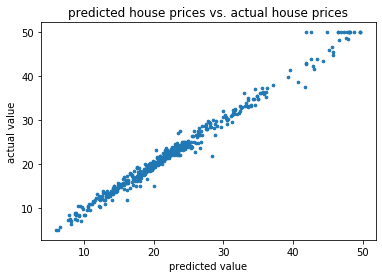

In [21]:
y_hat = best_forest.predict(x)
plt.scatter(y_hat, y, s=7)
plt.title('predicted house prices vs. actual house prices')
plt.xlabel('predicted value')
plt.ylabel('actual value')

## Using Decision Tree and Random Forest for Digits Classification
Remeber the MNIST dataset used - you will now test the power of decision trees on this problem.
This time you are given a free hand in choosing the test and train set sizes, model parameters (such as gain function and constraints over the trees) and features (whether to use binary pixel values or the original continous gray value).
- Choose which model parameters you wish to optimize, explain how would you do that, and find a model which you believe would have the minimal generalization error --- do this for both a single decision tree model, and a random forest.
  - You can use `sklearn.tree.DecisionTreeClassifier` and `sklearn.ensemble.RandomForestClassifier`
- Once you are satisfied with the model parameters, plot for each of the models (a single decision tree and random forest) the importance of each of the pixels to the final decision.
- Last, estimate the class assignment probabilities for all the correctly classified and misclassified examples in your test data.
- Discuss your results.

## Load The Data and Check The Default Models Performance

In [1]:
# code and answer go here
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv('mnist_784.csv')

X = df.drop('class',axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

df.head()

/home/uri/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from PIL import Image as im
import numpy as np

# DecisionTreeClassifier default performance
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)
accuracy_score(clf.predict(X_test),y_test)

/home/uri/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/uri/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/uri/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


0.8708571428571429

In [3]:
# RandomForestClassifier default performance
random_clf = RandomForestClassifier()
random_clf.fit(X_train,y_train)
accuracy_score(random_clf.predict(X_test),y_test)

0.9675714285714285

In [21]:
# Testing RandomForestClassifier on a single example  
sample = X.iloc[2].astype(np.uint8).to_numpy().reshape(28,28)
image = im.fromarray(sample)
image.resize((16,16))
print('prediction: %s' % random_clf.predict(X)[2])
print('---- \n fig:')
image

prediction: 4
---- 
 fig:


## Choosing Data Set Size

In [4]:
# to reduce computing time, 
# let's check at what point our model has enough data (i.e more data will not improve it dramatically)

performance_list = []

for sample_size in [1000,5000,10000,15000,20000,30000,35000,40000,45000,50000,len(df)]:
    sample_df = df.sample(sample_size)

    sample_X = sample_df.drop('class',axis=1)
    sample_y = sample_df['class']

    X_train, X_test, y_train, y_test = train_test_split(
        sample_X, sample_y, test_size=0.2, random_state=42)


    tree = DecisionTreeClassifier()
    rand_forest = RandomForestClassifier()
    
    tree.fit(X_train,y_train)
    rand_forest.fit(X_train,y_train)
    
    tree_acc = accuracy_score(tree.predict(X_test),y_test)
    rand_forest_acc = accuracy_score(rand_forest.predict(X_test),y_test)
    performance_list.append({'sample_size':sample_size,'Decision Tree Acc':tree_acc,'Random Forest Acc':rand_forest_acc})
performance_df = pd.DataFrame(performance_list)
performance_df

,sample_size,Decision Tree Acc,Random Forest Acc
0,1000,0.610000,0.820000
1,5000,0.778000,0.941000
2,10000,0.810000,0.944000
3,15000,0.812667,0.957333
4,20000,0.828750,0.952500
5,30000,0.835167,0.958833
6,35000,0.852571,0.964143
7,40000,0.861250,0.964750
8,45000,0.854667,0.963444
9,50000,0.859900,0.964300


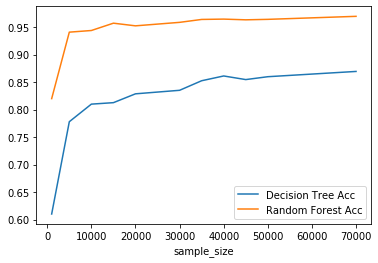

In [5]:
# as the graph shows, our model performnce is not getting better around ~35K for DT
# for RF we can take 20K
performance_df.set_index('sample_size').plot();

## Choosing test / train size

In [6]:
# choosing test / train size
sub_df = df.sample(35000)

X = sub_df.drop('class',axis=1)
y = sub_df['class']

performance_list = []

for test_size in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42)

    tree = DecisionTreeClassifier()
    rand_forest = RandomForestClassifier()
    
    tree.fit(X_train,y_train)
    rand_forest.fit(X_train,y_train)
    
    tree_acc = accuracy_score(tree.predict(X_test),y_test)
    rand_forest_acc = accuracy_score(rand_forest.predict(X_test),y_test)
    performance_list.append({'test_size':test_size,'Decision Tree Acc':tree_acc,'Random Forest Acc':rand_forest_acc})
    
performance_df = pd.DataFrame(performance_list)
performance_df

,test_size,Decision Tree Acc,Random Forest Acc
0,0.1,0.863714,0.961714
1,0.2,0.841571,0.961857
2,0.3,0.842000,0.959333
3,0.4,0.836929,0.959500
4,0.5,0.830343,0.956743
5,0.6,0.820857,0.954238
6,0.7,0.811918,0.951633
7,0.8,0.788214,0.945214
8,0.9,0.759206,0.933048


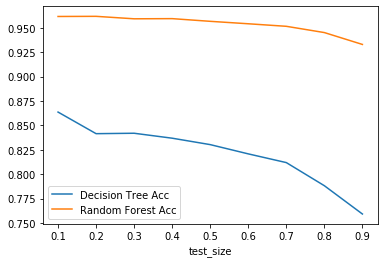

In [7]:
# as the graph shows, our models are best performing around 0.2 test size
performance_df.set_index('test_size').plot();

## Hyperparameters Selection (DecisionTree)
We found an optimual data set size and optimum (DecisionTreeClassifier: ~35K for DT & ~20K for RF) <br>
Now, let's use GridSearchCV to find the optimual hyperparameters <br>

GridSearchCV will generate all possible models from the param_grid we passed to it and <br>
will return the one with the higher performance 

In [8]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

test_size = 0.2
sample_size = 35000

sample_df = df.sample(sample_size)

sample_X = sample_df.drop('class',axis=1)
sample_y = sample_df['class']

X_train, X_test, y_train, y_test = train_test_split(
    sample_X, sample_y, test_size=test_size, random_state=42)

param_grid = {'criterion': ['gini','entropy'],'splitter':['best','random'],
              'max_depth':[3,5,10],'min_samples_split':[2,5,10]}
search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5,scoring=make_scorer(accuracy_score))
search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                   

In [9]:
# Conclusion - the models' performance are equivalent
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)
print('default model performance %s' % accuracy_score(clf.predict(X_test),y_test))
print('GridSearchCV model performance %s' % search.best_score_)
print('GridSearchCV model parameters %s' % search.best_params_)

default model performance 0.8468571428571429
GridSearchCV model performance 0.8470357142857143
GridSearchCV model parameters {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10, 'splitter': 'best'}


## Hyperparameters Selection (RandomForest)
Since Random Forest is more consuming in terms of training time, let's use RandomizedSearchCV to find the optimual hyperparameters <br>

RandomizedSearchCV will generate all possible parameters combinations from the param_grid we passed to it, uniformly sample from this combinations, and using this samples it will test the model performance <br>

In [10]:
test_size = 0.2
sample_size = 20000

sample_df = df.sample(sample_size)

sample_X = sample_df.drop('class',axis=1)
sample_y = sample_df['class']

X_train, X_test, y_train, y_test = train_test_split(
    sample_X, sample_y, test_size=test_size, random_state=42)

param_grid = {'criterion': ['gini','entropy'],'n_estimators':[50,100,150,200],
              'max_depth':[None,3, 5, 10,15, 20],'min_samples_split':[2,5,10],'min_samples_leaf':[1,2,3],
             'max_features': ['auto','sqrt','log2']}

search = RandomizedSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring=make_scorer(accuracy_score))
search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [11]:
# Conclusion - the models' performance are almost equivalent
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
print('default model performance %s' % accuracy_score(clf.predict(X_test),y_test))
print('GridSearchCV model performance %s' % search.best_score_)
print('GridSearchCV model parameters %s' % search.best_params_)

default model performance 0.9575
GridSearchCV model performance 0.9489375000000001
GridSearchCV model parameters {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'criterion': 'entropy'}


## Feature Importance (DecisionTreeClassifier)

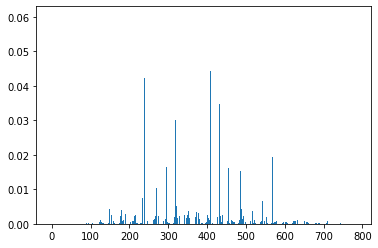

In [12]:
import matplotlib.pyplot as plt

clf = DecisionTreeClassifier()
clf.fit(X,y)

importance = clf.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## Feature Importance (RandomForestClassifier)

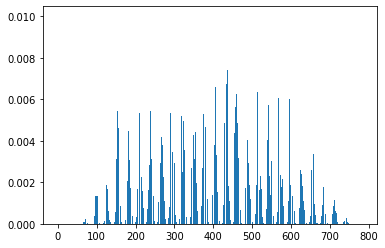

In [13]:
import matplotlib.pyplot as plt

clf = RandomForestClassifier()

clf.fit(X,y)

importance = clf.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## Class Assignment Estimation (DecisionTreeClassifier)

In [14]:
from sklearn.metrics import confusion_matrix

clf = DecisionTreeClassifier()

X = df.drop('class',axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

clf.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

/home/uri/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


precision_score - 0.8732869026837553
recall_score - 0.8733571428571428


,0,1,2,3,4,5,6,7,8,9
0,91.48%,0.12%,1.51%,0.35%,0.59%,1.43%,1.97%,0.27%,1.04%,0.64%
1,0.22%,94.72%,0.53%,0.56%,0.67%,0.87%,0.56%,0.80%,1.04%,0.28%
2,1.33%,1.18%,86.88%,2.79%,1.70%,1.19%,2.18%,1.54%,3.34%,0.99%
3,0.81%,0.50%,2.71%,84.17%,0.67%,5.16%,0.63%,1.67%,2.45%,2.12%
4,0.89%,0.19%,1.06%,0.49%,84.28%,0.63%,1.27%,0.74%,1.86%,4.25%
5,1.78%,0.87%,1.06%,4.60%,1.41%,83.10%,1.76%,0.13%,3.04%,1.49%
6,1.56%,0.37%,0.53%,0.42%,1.63%,2.30%,89.44%,0.27%,1.93%,0.35%
7,0.22%,0.75%,1.28%,1.26%,1.63%,0.48%,0.28%,91.49%,1.11%,2.83%
8,0.96%,0.93%,3.24%,3.63%,2.37%,2.86%,1.34%,0.74%,81.51%,2.69%
9,0.74%,0.37%,1.21%,1.74%,5.04%,1.98%,0.56%,2.34%,2.67%,84.35%


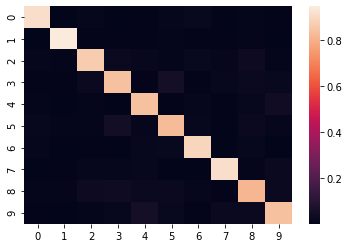

In [15]:
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
conf_matrix = pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test)))
pct_matrix = conf_matrix / conf_matrix.sum()
sns.heatmap(pct_matrix);
for col in pct_matrix:
    pct_matrix[col] = pct_matrix[col].map("{:.2%}".format)
print('precision_score - %s' % precision_score(y_test,clf.predict(X_test),average='weighted'))
print('recall_score - %s' % recall_score(y_test,clf.predict(X_test),average='weighted'))
pct_matrix


## Class Assignment Estimation (RandomForestClassifier)

In [16]:
clf = RandomForestClassifier()

clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

precision_score - 0.9671744857662585
recall_score - 0.9671428571428572


,0,1,2,3,4,5,6,7,8,9
0,98.43%,0.00%,0.42%,0.00%,0.15%,0.08%,0.28%,0.07%,0.67%,0.07%
1,0.00%,98.26%,0.42%,0.43%,0.15%,0.00%,0.00%,0.40%,0.15%,0.00%
2,0.15%,0.31%,94.63%,0.07%,0.31%,0.16%,0.50%,0.47%,0.59%,0.28%
3,0.15%,0.00%,1.62%,96.38%,0.08%,0.95%,0.14%,1.06%,0.82%,0.56%
4,0.15%,0.06%,0.21%,0.00%,96.61%,0.00%,0.28%,0.20%,0.15%,1.91%
5,0.22%,0.19%,0.14%,1.21%,0.23%,97.30%,0.57%,0.07%,0.59%,0.14%
6,0.22%,0.06%,0.07%,0.00%,0.39%,0.63%,97.80%,0.00%,0.22%,0.00%
7,0.15%,0.37%,1.34%,0.00%,0.39%,0.00%,0.00%,96.61%,0.15%,1.13%
8,0.07%,0.44%,0.85%,0.85%,0.54%,0.63%,0.36%,0.33%,95.84%,0.71%
9,0.45%,0.31%,0.28%,1.06%,1.16%,0.24%,0.07%,0.80%,0.82%,95.20%


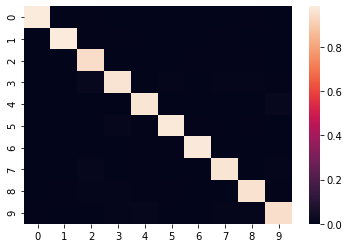

In [17]:
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
conf_matrix = pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test)))
pct_matrix = conf_matrix / conf_matrix.sum()
sns.heatmap(pct_matrix);
for col in pct_matrix:
    pct_matrix[col] = pct_matrix[col].map("{:.2%}".format)
print('precision_score - %s' % precision_score(y_test,clf.predict(X_test),average='weighted'))
print('recall_score - %s' % recall_score(y_test,clf.predict(X_test),average='weighted'))
pct_matrix


## Discussion
In this question we formed two classifiers - random forest & decision tree and we test thier performnce for the MNIST data set.<br> First we tried to find the optimal dataset size & test size by testing the accuracy_score for different dataset & test sizes.<br> 
<tab>    Note: At this point we must say accuracy_score is just one metric to evaluate a model performance.<br> We might choose different hyperparameters for a different evaluations metrics.
<br>    
Next, we tried to find the optimal hyperparameters by using grid search method. after applying this methods we couldn't acheive better performance compared to the default parameters. We would still prefer the model with the optimal parameters from the gridsearch, because it will likely generalise better than the default.
<br>    
We then plotted the pixels importance for both of our models. as we expected, there is a bias toward the center of each pixels row, which can be seen in the plots as many "mini normal distributions".<br>
We also noticed there center rows of pixels are more important, which translated to a general "normal distribution" in the two plots.<br>  
Lastly, we presented the confusion matrix for the two models. The most common mistake in both models was classifying 4 as 9, which make sense given the digits shapes.

## References
- https://www.analyticsvidhya.com/blog/2014/06/introduction-random-forest-simplified/